In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

!pip3 install tensorflow_hub
import tensorflow_hub as hub


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers


In [3]:
data_file = "../../data/data_stat.txt"
dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")

In [4]:
dtf.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text_x', 'Text_y', 'Score'], dtype='object')

In [5]:
text_x = dtf["Text_x"]
text_y = dtf["Text_y"]
score = dtf["Score"]

In [5]:
score

0       2
1       1
2       1
3       1
4       1
       ..
3311    1
3312    2
3313    1
3314    1
3315    1
Name: Score, Length: 3316, dtype: int64

In [6]:
count_score = score.astype("str").astype("category").value_counts().tolist()

In [5]:
count_score

[2398, 380, 279, 158, 53, 46, 2]

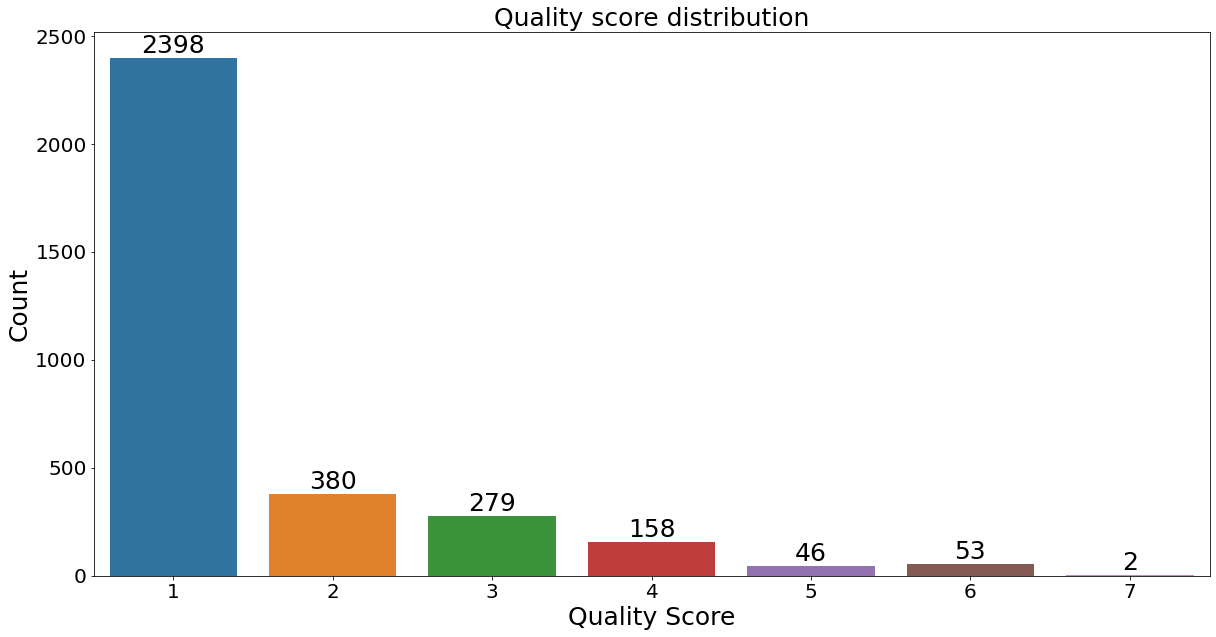

In [7]:
plt.figure(figsize=(20,10))
g = sns.countplot(x = score)
plt.title("Quality score distribution", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Quality Score",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

In [8]:
length_x = text_x.apply(lambda line: len(line)).mean()

In [9]:
length_y = text_y.apply(lambda line: len(line)).mean()

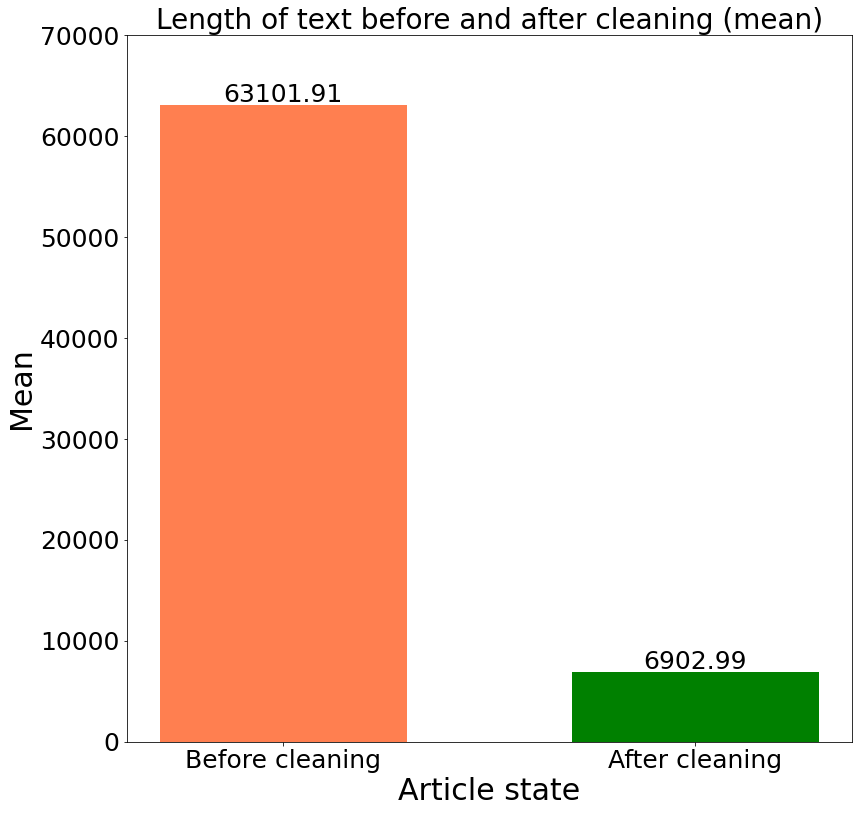

In [10]:

figure, axes = plt.subplots()
figure.set_figheight(13)
figure.set_figwidth(13)
plt.bar(["Before cleaning","After cleaning"], [length_x, length_y] , width = 0.6, color = ["coral", "green"])
plt.ylim(0,70000)

for p in axes.patches:
    axes.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points', fontsize = 25)

plt.xlabel("Article state",fontsize = 30)
plt.ylabel("Mean",fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.title("Length of text before and after cleaning (mean)", fontsize = 28)
plt.show()